# Fitting normative models on a compute cluster

This notebook will go through the options of the runner class. We will show how to fit and evaluate a model in parallel, and how to do cross-validation. 

You can run this notebook on a login node, but it is recommended to run it on a compute node. The notebook is tailored to the Slurm environment on the Donders HPC cluster, but can be adapted to other Slurm or Torque environments. 

### IMPORTANT
This notebook is just a demo for a small dataset. The same code can be applied to larger datasets, but keep in mind that the this notebook loads the whole dataset into memory before chunking it. If you are running this notebook on a login node, you will quickly run into memory issues if you load big datasets. In that case, you can either create a .py file with the same code and run that in an interactive job with sufficient memory, or you can use my [guide to running notebooks on a cluster](https://github.com/AuguB/guide_to_cluster_notebooks_on_vscode). 

## Setting up the environment on the cluster

First, SSH into the cluster. If you are using VScode, you can use the Remote - SSH extension to connect to the cluster. It's a breeze. 

We start with a clean environment and install the PCNtoolkit package. We do this in an interactive job.

```bash
sbash --time=01:00:00 --mem=16gb -c 4 --ntasks-per-node=1
module load anaconda3
conda create -n pcntoolkit_cluster_tutorial python=3.12
source activate pcntoolkit_cluster_tutorial
pip install pcntoolkit
pip install ipykernel
pip install graphviz
```

Next, we want to use the newly created environment in our notebook. 

If you are running this notebook in VScode, you can select the environment by clicking on the mysterious symbol in the top right corner of the notebook. 

Click "Select Another Kernel...", "Python environments...", and then from the dropdown, select the `pcntoolkit_cluster_tutorial` environment. 

You may have to reload the window after creating the environment before it is available in VScode -> Open the command palette (mac: cmd+shift+P, windows: ctrl+shift+P) and type "Reload Window"

After selecting the environment, the weird symbol in the top right corner should now show the environment name. 

### Imports

In [1]:
import os
import sys
import warnings
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pcntoolkit import (
    BLR,
    BsplineBasisFunction,
    NormativeModel,
    NormData,
    load_fcon1000,
    plot_centiles,
    Runner,
)
import pcntoolkit.util.output

sns.set_theme(style="darkgrid")

# Get the conda environment path
conda_env_path = os.path.join(os.path.dirname(os.path.dirname(sys.executable)))
print(f"This should be the conda environment path: {conda_env_path}")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")
pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(True)

This should be the conda environment path: /project/3022000.05/projects/stijdboe/envs/pcntoolkit_cluster_tutorial


In [2]:
# Download the dataset
norm_data: NormData = load_fcon1000()
features_to_model = [
    "WM-hypointensities",
    "Right-Lateral-Ventricle",
    "Right-Amygdala",
    "CortexVol",
]
# Select only a few features
norm_data = norm_data.sel({"response_vars": features_to_model})
# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.batch_effects_split({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

NameError: name 'load_fcon1000' is not defined

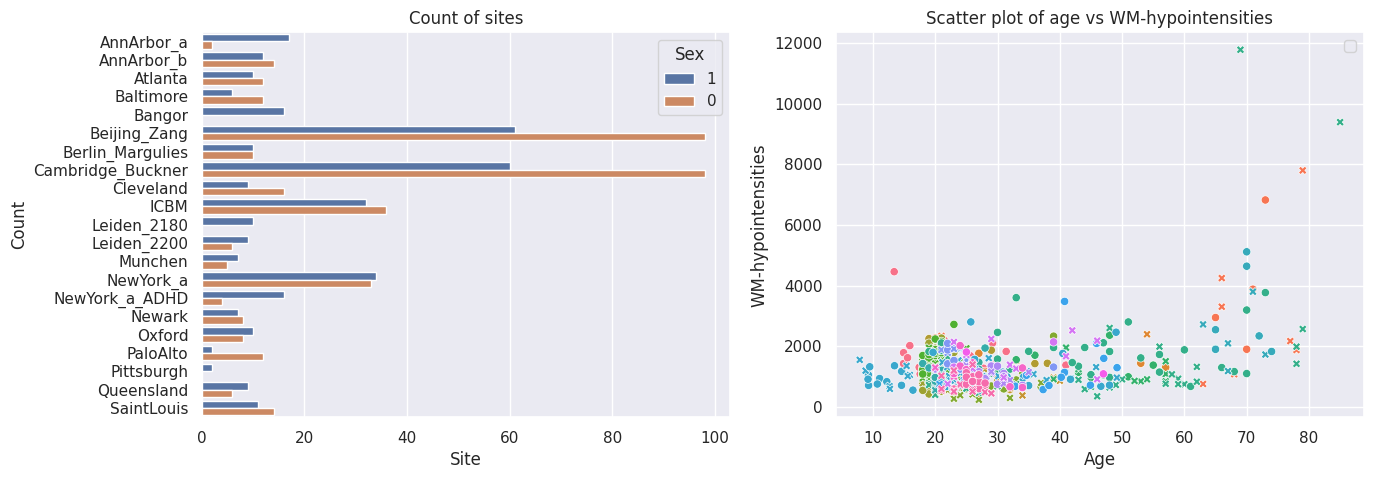

In [3]:
# Inspect the data
feature_to_plot = features_to_model[0]
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")


sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

## Configure the regression model


In [4]:
# Heteroskedastic BLR model with sinharcsinh warp
blr_regression_model = BLR(
    n_iter=1000,
    tol=1e-8,
    optimizer="l-bfgs-b",
    l_bfgs_b_epsilon=0.1,
    l_bfgs_b_l=0.1,
    l_bfgs_b_norm="l2",
    warp_name="WarpSinhArcSinh",
    warp_reparam=True,
    fixed_effect=True,
    basis_function_mean=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    heteroskedastic=True,
    basis_function_var=BsplineBasisFunction(basis_column=0, degree=3, nknots=5),
    fixed_effect_var=False,
)

In [5]:
model = NormativeModel(
    template_regression_model=blr_regression_model,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="resources/blr/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="standardize",
)

## Fit the model
Normally we would just call 'fit_predict' on the model directly, but because we want to use the runner to fit our models in parallel, we need to first create a runner object. 

In [6]:
runner = Runner(
    cross_validate=False,
    parallelize=True,
    environment=conda_env_path,
    job_type="slurm",  # or "torque" if you are on a torque cluster
    n_batches=2,
    time_limit="00:10:00",
    log_dir="resources/runner_output/log_dir",
    temp_dir="resources/runner_output/temp_dir",
)

Now we can just do:

In [7]:
runner.fit_predict(
    model, train, test
)  # With observe=True, you will see a job status monitor until the jobs are done. With observe=False, the runner will just create and start the jobs and release the notebook.


---------------------------------------------------------
              PCNtoolkit Job Status Monitor ®
---------------------------------------------------------
Task ID: fit_predict_fit_train__2025-05-13_18:57:24_978.359375
---------------------------------------------------------
Job ID      Name          State      Time      Nodes
---------------------------------------------------------

47348486    fit_predict_fit_train__2025-05-13_18:57:24_978.359375_job_0 COMPLETED                          
47348487    fit_predict_fit_train__2025-05-13_18:57:24_978.359375_job_1 COMPLETED                          

---------------------------------------------------------
Total active jobs: 0
Total completed jobs: 2
Total failed jobs: 0
---------------------------------------------------------


---------------------------------------------------------
No more running jobs!
---------------------------------------------------------



### Loading a fold model
We can load a model for a specific fold by calling `load_model` on the runner object. This will return a `NormativeModel`, which we can inspect and use to predict on new data.


Process: 2343784 - 2025-05-13 18:58:22 - Dataset "synthesized" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 4 response variables
    - 2 batch effects:
    	sex (2)
	site (18)
    
Process: 2343784 - 2025-05-13 18:58:22 - Synthesizing data for 4 response variables.
Process: 2343784 - 2025-05-13 18:58:22 - Synthesizing data for Right-Lateral-Ventricle.
Process: 2343784 - 2025-05-13 18:58:22 - Synthesizing data for CortexVol.
Process: 2343784 - 2025-05-13 18:58:22 - Synthesizing data for WM-hypointensities.
Process: 2343784 - 2025-05-13 18:58:22 - Synthesizing data for Right-Amygdala.
Process: 2343784 - 2025-05-13 18:58:22 - Computing centiles for 4 response variables.
Process: 2343784 - 2025-05-13 18:58:22 - Computing centiles for CortexVol.
Process: 2343784 - 2025-05-13 18:58:22 - Computing centiles for WM-hypointensities.
Process: 2343784 - 2025-05-13 18:58:22 - Computing centiles for Right-Lateral-Ventricle.
Process: 2343784 - 2025-05-13 18:58:22

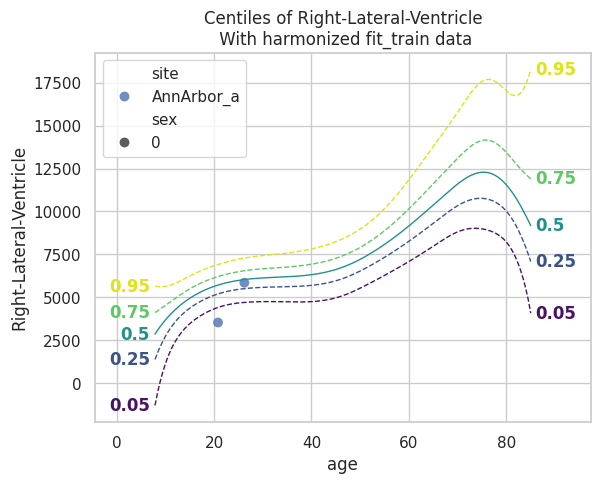

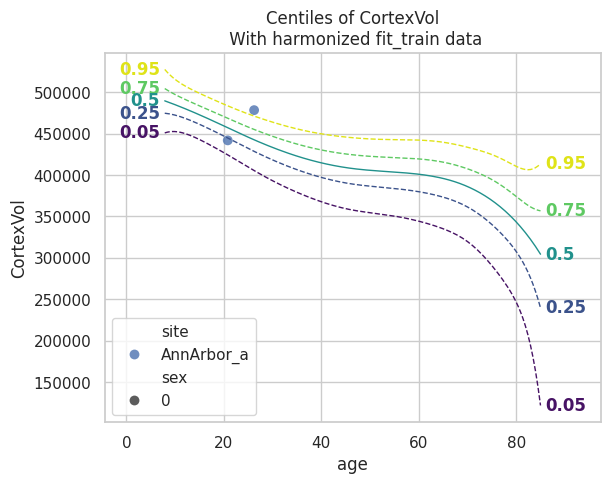

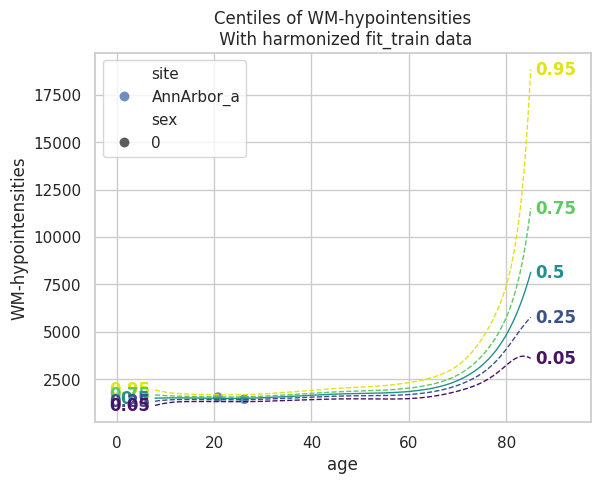

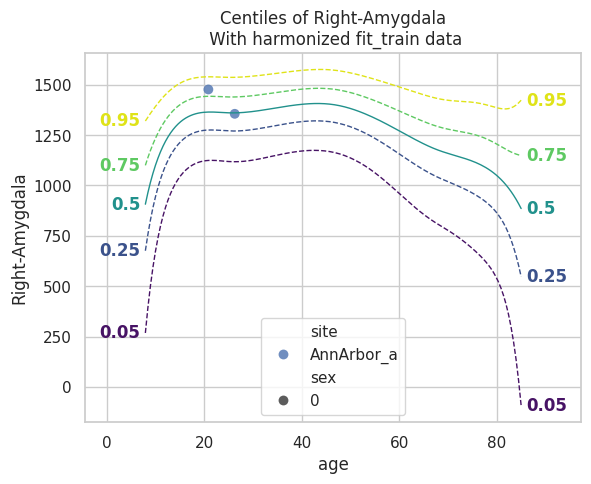

In [8]:
runner.load_model()
plot_centiles(model, scatter_data=train)

## Model extension

BLR models can only be extended, not transferred (yet).


In [9]:
runner.extend_predict(model, transfer_train, transfer_test)


---------------------------------------------------------
              PCNtoolkit Job Status Monitor ®
---------------------------------------------------------
Task ID: extend_predict_transfer_train__2025-05-13_19:00:23_811.056152
---------------------------------------------------------
Job ID      Name          State      Time      Nodes
---------------------------------------------------------

47348491    extend_predict_transfer_train__2025-05-13_19:00:23_811.056152_job_0 COMPLETED                          
47348492    extend_predict_transfer_train__2025-05-13_19:00:23_811.056152_job_1 COMPLETED                          

---------------------------------------------------------
Total active jobs: 0
Total completed jobs: 2
Total failed jobs: 0
---------------------------------------------------------


---------------------------------------------------------
No more running jobs!
---------------------------------------------------------



Datasets with a zscores DataArray will have the `.plot_qq()` function available:

## More to do with the runner

The following functions are available:
- `transfer(transfer_data)`: Transfer the model to transfer_data.
- `extend(extend_data)`: Extend the model to extend_data.
- `transfer_predict(transfer_data, transfer_test)`: Transfer to transfer_test and predict on transfer_test.
- `extend_predict(extend_data, extend_test)`: Extend to extend_test and predict on extend_test.